In [ ]:
!pip install numpy
!pip install pandas
!pip install opencv_python
!pip install keras
!pip install tensorflow
!pip install h5py
!pip install tensorflow-gpu
!pip install pydot

# Import dataset from Kaggle

In [ ]:
!pip install kaggle

Upload Kagge API key to download data

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [2]:
!kaggle datasets download -d gauravsharma99/ck48-5-emotions

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 37.3MB/s]


In [3]:
!unzip -n -q ck48-5-emotions.zip

# Prepare data

In [4]:
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

In [5]:
import os
from collections import defaultdict

INPUT_PATH = "CK+48/"
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    print(f"{dir_} has {count} number of images")

anger has 135 number of images
fear has 75 number of images
sadness has 84 number of images
surprise has 249 number of images
happy has 207 number of images


In [6]:
TOP_EMOTIONS = ["surprise", "happy", "anger", "sadness", "fear"]

In [7]:
data = defaultdict(str)
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        data[dir_] = defaultdict(list)
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            sub = f.split("_")[0]
            data[dir_][sub].append(f)

In [8]:
def preprocess_list(x):
    return int((x.split("_")[2]).split(".")[0])


def preprocess_dict(x):
    res = list(np.argsort(list(map(preprocess_list, x))))
    return [x[i] for i in res]


def image_to_array(x, path):
    arr = np.empty(shape=(3, 48, 48))
    for i, f in enumerate(x):
        img = cv2.imread(path + f, 0)
        arr[i] = img
    return arr

In [9]:
for emotion in data:
    data[emotion] = dict((k, preprocess_dict(v)) for k, v in data[emotion].items())
    data[emotion] = dict((k, image_to_array(v, path=INPUT_PATH + emotion + "/")) for k, v in data[emotion].items())

In [10]:
for k, v in data.items():
    print(f"{k} has {len(v)} samples")

anger has 45 samples
fear has 25 samples
sadness has 28 samples
surprise has 83 samples
happy has 69 samples


In [11]:
def prepare_emotion_set(emotion_name):
    em_set = np.stack(data[emotion_name].values(), axis=0)
    return em_set.reshape(*em_set.shape, 1)


surprise = prepare_emotion_set("surprise")
happy = prepare_emotion_set("happy")
anger = prepare_emotion_set("anger")
sadness = prepare_emotion_set("sadness")
fear = prepare_emotion_set("fear")

for emotion in TOP_EMOTIONS:
    temp = np.stack(data[emotion].values(), axis=0)
    temp = temp.reshape(*temp.shape, 1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [12]:

label_emotion_mapper = {0: "surprise", 1: "happy", 2: "anger", 3: "sadness", 4: "fear"}


def split_data():
    X = np.concatenate((surprise, happy, anger, sadness, fear))
    y = np.concatenate(
        (np.array([0] * 83), np.array([1] * 69), np.array([2] * 45), np.array([3] * 28), np.array([4] * 25)))
    y = to_categorical(y)
    print(X.shape, y.shape)  # (250, 3, 48, 48, 1), (250, 5)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        train_size=0.7,
        stratify=y,
        shuffle=True,
        random_state=42
    )
    return X_train, X_valid, y_train, y_valid


X_train, X_valid, y_train, y_valid = split_data()

print(X_train.shape, X_valid.shape) # (175, 3, 48, 48, 1), (75, 3, 48, 48, 1)

(250, 3, 48, 48, 1) (250, 5)
(175, 3, 48, 48, 1) (75, 3, 48, 48, 1)


Image normalization

In [13]:
def normalize(x):
    return 2 * (x / 255. - 0.5)


X_train = normalize(X_train)
X_valid = normalize(X_valid)

# Build Conv Net to exctract features from images

In [17]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.python.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, AveragePooling2D, LSTM, TimeDistributed
from tensorflow.keras.regularizers import l2

In [18]:
def build_dcnn(input_shape, show_arch=True):
    model = Sequential(name='DCNN')

    model.add(
        Conv2D(
            filters=64,
            kernel_size=(3, 3),
            input_shape=input_shape,
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(
        Conv2D(
            filters=64,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    model.add(BatchNormalization(name='batchnorm_2'))

    model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_1'))
    model.add(Dropout(0.45, name='dropout_1'))

    model.add(
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    model.add(BatchNormalization(name='batchnorm_3'))
    model.add(
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    model.add(BatchNormalization(name='batchnorm_4'))

    model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_2'))
    model.add(Dropout(0.45, name='dropout_2'))

    model.add(
        Conv2D(
            filters=256,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    model.add(BatchNormalization(name='batchnorm_5'))
    model.add(
        Conv2D(
            filters=256,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    model.add(BatchNormalization(name='batchnorm_6'))

    model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_3'))
    model.add(Dropout(0.4, name='dropout_3'))

    model.add(
        Conv2D(
            filters=512,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_7'
        )
    )
    model.add(BatchNormalization(name='batchnorm_7'))
    model.add(
        Conv2D(
            filters=512,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_8'
        )
    )
    model.add(BatchNormalization(name='batchnorm_8'))

    model.add(Dropout(0.4, name='dropout_4'))

    model.add(GlobalMaxPool2D(name="globalmax2d"))

    if show_arch:
        model.summary()

    return model

# Build LSTM

In [19]:
def memory_model(input_shape, num_class, show_arch=True):
    base_network = build_dcnn(input_shape[1:], show_arch=False)
    
    # keras.utils.plot_model(base_network, to_file='densenet_model.png', show_shapes=True)

    model = Sequential(name="convolutional_Bidrectional_LSTM")

    model.add(TimeDistributed(base_network, input_shape=input_shape, name="time_distributed"))

    model.add(Bidirectional(LSTM(128, return_sequences=True, name="bidirect_lstm_1")))
    model.add(Dropout(.35, name="dropout_lstm_1"))
    model.add(Bidirectional(LSTM(64, return_sequences=False, name="bidirect_lstm_2")))
    model.add(Dropout(.45, name="dropout_lstm_2"))

    model.add(Dense(128, activation='elu', kernel_initializer='he_normal', name='dense_1'))
    model.add(BatchNormalization(name='batchnorm_lstm_1'))
    model.add(Dropout(.7, name="dropout_lstm_3"))

    model.add(Dense(num_class, activation='softmax', name='out_layer'))

    if show_arch:
        model.summary()

    return model

# Callbacks

Scheduler

In [20]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

CSV logger

In [21]:
dataset_name = "ck+48"
log_file_path = dataset_name + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)


Model checkpoint

In [22]:
base_path = "content\\"
trained_models_path = base_path + dataset_name + 'lstm'
model_names = trained_models_path + '.{epoch:02d}-{val_loss:.2f}.hdf5'  # if error "acc" in 1 line ... don't confuse check entire block since fit() generates a inner loop
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1, save_best_only=True, save_weights_only=True)


Early stopping

In [23]:
early_stop = EarlyStopping('val_loss', patience=100)

Convolution matrix

In [24]:
# import io
# import itertools
# import sklearn.metrics

# from tensorflow import keras
# from tensorflow import summary
# from datetime import datetime



# def plot_confusion_matrix(cm, class_names):
#     """
#     Returns a matplotlib figure containing the plotted confusion matrix.

#     Args:
#        cm (array, shape = [n, n]): a confusion matrix of integer classes
#        class_names (array, shape = [n]): String names of the integer classes
#     """

#     figure = matplotlib.pyplot.figure(figsize=(8, 8))
#     matplotlib.pyplot.imshow(cm, interpolation='nearest', cmap=matplotlib.pyplot.cm.Blues)
#     matplotlib.pyplot.title("Confusion matrix")
#     matplotlib.pyplot.colorbar()
#     tick_marks = np.arange(len(class_names))
#     matplotlib.pyplot.xticks(tick_marks, class_names, rotation=45)
#     matplotlib.pyplot.yticks(tick_marks, class_names)

#     # Normalize the confusion matrix.
#     cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

#     # Use white text if squares are dark; otherwise black.
#     threshold = cm.max() / 2.

#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         color = "white" if cm[i, j] > threshold else "black"
#         matplotlib.pyplot.text(j, i, cm[i, j], horizontalalignment="center", color=color)

#     matplotlib.pyplot.tight_layout()
#     matplotlib.pyplot.ylabel('True label')
#     matplotlib.pyplot.xlabel('Predicted label')
#     return figure


# # Create log directory
# logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# # Define a TensorBoard callback. Use the log_dir parameter
# # to specify the path to the directory where you want to save the
# # log files to be parsed by TensorBoard.
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

# file_writer_cm = summary.create_file_writer(logdir + '/cm')


# def plot_to_image(figure):
#     """
#     Converts the matplotlib plot specified by 'figure' to a PNG image and
#     returns it. The supplied figure is closed and inaccessible after this call.
#     """

#     buf = io.BytesIO()

#     # Use plt.savefig to save the plot to a PNG in memory.
#     matplotlib.pyplot.savefig(buf, format='png')
#     # plt.show()

#     # Closing the figure prevents it from being displayed directly inside
#     # the notebook.
#     matplotlib.pyplot.close(figure)
#     buf.seek(0)

#     # Use tf.image.decode_png to convert the PNG buffer
#     # to a TF image. Make sure you use 4 channels.
#     image = image.decode_png(buf.getvalue(), channels=4)

#     # Use tf.expand_dims to add the batch dimension
#     image = expand_dims(image, 0)

#     return image


# def log_confusion_matrix(epoch, logs):
#     # Use the model to predict the values from the test_images.
#     test_pred_raw = model.predict(X_valid)

#     test_pred = np.argmax(test_pred_raw, axis=1)

#     test_labels = np.argmax(y_valid, axis=1)

#     # Calculate the confusion matrix using sklearn.metrics
#     cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)

#     figure = plot_confusion_matrix(cm, class_names=TOP_EMOTIONS)
#     cm_image = plot_to_image(figure)

#     # Log the confusion matrix as an image summary.
#     with file_writer_cm.as_default():
#         summary.image("Confusion Matrix", cm_image, step=epoch)


# # Define the per-epoch callback.
# cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [25]:
callbacks = [
    early_stop, lr_scheduler
]

In [26]:
batch_size = 32
epochs = 150

INPUT_SHAPE = (3, 48, 48, 1)
optim = optimizers.Nadam(0.001)

model = memory_model(INPUT_SHAPE, num_class=5)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy']
)

Model: "convolutional_Bidrectional_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 3, 512)            4691904   
_________________________________________________________________
bidirectional (Bidirectional (None, 3, 256)            656384    
_________________________________________________________________
dropout_lstm_1 (Dropout)     (None, 3, 256)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_lstm_2 (Dropout)     (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batchnorm_lstm_1 (BatchNorma (None,

# Train network

In [27]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/10
6/6 [==============================] - 45s 591ms/step - loss: 3.4293 - accuracy: 0.1486 - val_loss: 1.5564 - val_accuracy: 0.3067
Epoch 2/10
6/6 [==============================] - 1s 100ms/step - loss: 2.9368 - accuracy: 0.2971 - val_loss: 1.5805 - val_accuracy: 0.3333
Epoch 3/10
6/6 [==============================] - 1s 102ms/step - loss: 3.1034 - accuracy: 0.2057 - val_loss: 1.5547 - val_accuracy: 0.3467
Epoch 4/10
6/6 [==============================] - 1s 101ms/step - loss: 2.8440 - accuracy: 0.2571 - val_loss: 1.5455 - val_accuracy: 0.2667
Epoch 5/10
6/6 [==============================] - 1s 100ms/step - loss: 2.8627 - accuracy: 0.2114 - val_loss: 1.5475 - val_accuracy: 0.2800
Epoch 6/10
6/6 [==============================] - 1s 101ms/step - loss: 2.8912 - accuracy: 0.2286 - val_loss: 1.5086 - val_accuracy: 0.2933
Epoch 7/10
6/6 [==============================] - 1s 102ms/step - loss: 2.7193 - accuracy: 0.2229 - val_loss: 1.5114 - val_accuracy: 0.3467
Epoch 8/10
6/6 [===

# Check results

Training and validation loss

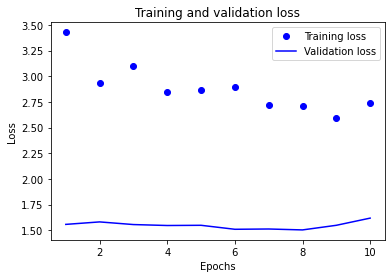

In [28]:
history_dict = history.history

train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_ = range(1, len(history_dict['accuracy']) + 1)

pyplot.plot(epochs_, train_loss_values, 'bo', label='Training loss')
pyplot.plot(epochs_, val_loss_values, 'b', label='Validation loss')
pyplot.title('Training and validation loss')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.show()

Training and validation accuracy

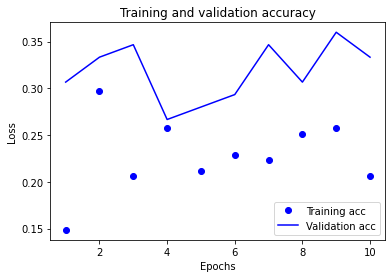

In [29]:
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
pyplot.plot(epochs_, train_acc, 'bo', label='Training acc')
pyplot.plot(epochs_, val_acc, 'b', label='Validation acc')
pyplot.title('Training and validation accuracy')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.show()

Model architecture

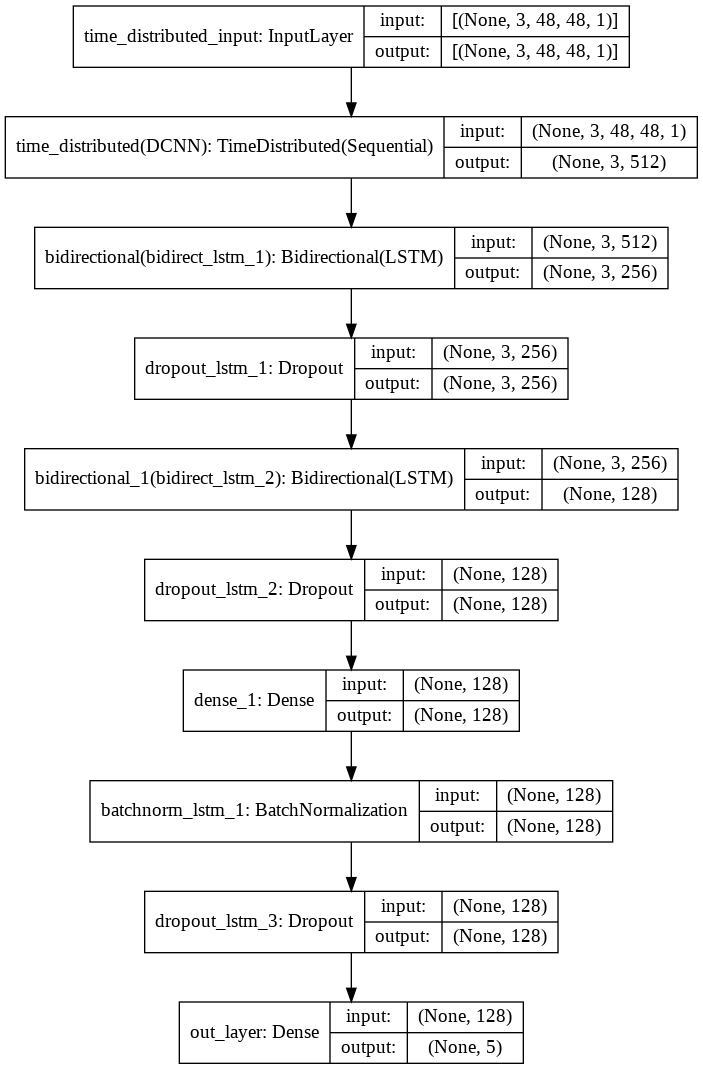

In [30]:
keras.utils.plot_model(model, to_file='lstm_densenet_model.png', show_shapes=True)


Some examples from the set

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


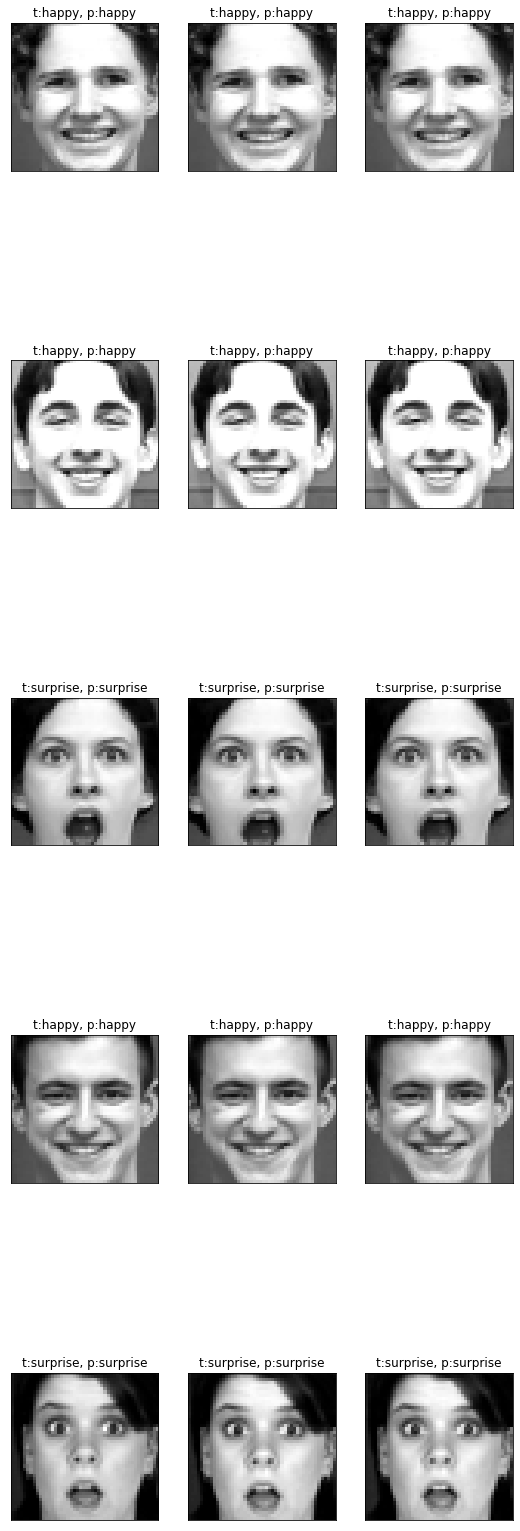

In [31]:
np.random.seed(0)
indices = np.random.choice(range(X_valid.shape[0]), size=5, replace=False)

fig = pyplot.figure(1, (9, 30))

i = 0
for idx in indices:
    true_emotion = label_emotion_mapper[np.argmax(y_valid[idx])]
    pred_emotion = label_emotion_mapper[model.predict_classes(np.expand_dims(X_valid[idx], axis=0))[0]]

    for j in range(3):
        i += 1
        ax = pyplot.subplot(5, 3, i)
        sample_img = X_valid[idx, j, :, :, 0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:{true_emotion}, p:{pred_emotion}")

pyplot.show()

Confusion matrix

In [32]:
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
pred=np.argmax(pred, axis=1)
y_test=np.argmax(y_train, axis=1)

conf = confusion_matrix(y_test, pred)

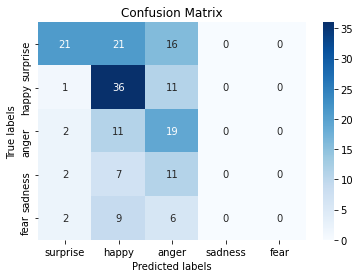

In [33]:
import seaborn as sns
ax=pyplot.subplot()

sns.heatmap(conf, annot=True, fmt='g', cmap='Blues', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(TOP_EMOTIONS);
ax.yaxis.set_ticklabels(TOP_EMOTIONS);

Model can be saved using the following command:
```
from datetime import datetime
model.save(datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + str(epochs) + "_lstm_densenet_model_tf.h5")
```

